## TCGA germline data pre-processing

Import TCGA data into Hail, perform marker QC, impute using TOPMED server, filter to high-quality imputed sites.

### Download data

TCGA germline array data can be downloaded from GDC Legacy Archive in birdseed format (controlled access).

### Convert to merged VCF

See script merge_TCGA.R, adapted from https://github.com/siddhartha-kar/tcga-imputation, I have modified these scripts to remove the SNP/sample filtering by call rate (this will be done in Hail) and to retain palindromic SNPs (as all data will be aligned to forward strand).

In [ ]:
%%bash

Rscript merge_tcga.R

Remove missing calls (defined as '-1' in original birdseed file), see https://groups.google.com/a/broadinstitute.org/g/gdac-users/c/fR1cl1XoG2s, implemented with sed.

In [ ]:
%%bash

cd /mnt/grid/janowitz/rdata_norepl/tcga_germline/vcf
cat ../scripts/header_new.hr tcga_mergexy_vcf.txt > tcga_merge.vcf

sed -i 's|-1|./.|g' tcga_merge.vcf

~/miniconda3/bin/bgzip -f tcga_merge.vcf

### Import into Hail

#### Load Hail

In [1]:
import seaborn as sns
import hail as hl
import os
from gnomad.utils.liftover import *
from gnomad.utils.annotations import *
from gnomad.sample_qc.pipeline import *
from gnomad.sample_qc.ancestry import *

tmp = "/mnt/grid/janowitz/home/skleeman/tmp2"
os.environ["SPARK_LOCAL_DIRS"]=tmp

os.environ["PYSPARK_SUBMIT_ARGS"] ="--driver-memory 200g --executor-memory 2g pyspark-shell"

hl.init(default_reference='GRCh38', master='local[16]',min_block_size=128, local_tmpdir=tmp, tmp_dir=tmp)


Running on Apache Spark version 3.1.1
SparkUI available at http://bam23.cm.cluster:4041
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.67-40d373134612
LOGGING: writing to /grid/wsbs/home_norepl/skleeman/hail-20220420-1520-0.2.67-40d373134612.log


#### Load VCF file

In [ ]:
mt = hl.import_vcf('/mnt/grid/janowitz/rdata_norepl/tcga_germline/vcf/tcga_merge.vcf.gz', force_bgz=True,
                   reference_genome='GRCh37')

mt = mt.checkpoint('/mnt/grid/janowitz/rdata_norepl/tcga_germline/hail/tcga_raw.mt', overwrite=True)

In [ ]:
mt.count()

## TCGA QC

### Sample QC

Sample QC steps mostly completed by authors of Immunity paper (https://www.sciencedirect.com/science/article/pii/S1074761321000340?via%3Dihub). One germline sample selected per TCGA subject (priority given to blood samples, and samples with higher call rates), samples with ancestry-specific excess heterozygosity were removed (n=250). TCGA subjects with with hematological malignancies (diffuse large B cell lymphoma, and acute myeloid leukemia) and thymoma were excluded.

#### Load TCGA clinical data

Downloaded from https://www.sciencedirect.com/science/article/pii/S0092867418302290?via%3Dihub.

In [ ]:
import pandas as pd

tcga_ref = pd.read_excel('/mnt/grid/janowitz/rdata_norepl/tcga_germline/hail/TCGA-CDR.xlsx')
tcga_ref = tcga_ref[['bcr_patient_barcode','type','age_at_initial_pathologic_diagnosis','gender']]
tcga_ref['bcr_patient_barcode'] = tcga_ref['bcr_patient_barcode'].replace('-','.', regex=True)
tcga_ref_ht = hl.Table.from_pandas(tcga_ref, key='bcr_patient_barcode') 
tcga_ref

#### Check for sex mismatch

This was not clearly performed in the Immunity paper so we have performed here, using the Hail implementation of the PLINK function.

In [ ]:
mt = hl.read_matrix_table('/mnt/grid/janowitz/rdata_norepl/tcga_germline/hail/tcga_raw.mt')
imputed_sex = hl.impute_sex(mt.GT)
imputed_sex = imputed_sex.annotate(tcga_is_female = hl.if_else(tcga_ref_ht[imputed_sex.s].gender=="FEMALE",True,False))
imputed_sex = imputed_sex.filter(imputed_sex.is_female != imputed_sex.tcga_is_female)
imputed_sex.count()

In [ ]:
#Import raw data
mt = hl.read_matrix_table('/mnt/grid/janowitz/rdata_norepl/tcga_germline/hail/tcga_raw.mt')

#Remove samples with detectable sex mismatch
mt = mt.filter_cols(hl.is_defined(imputed_sex[mt.s]), keep=False)
print(mt.count())

mt = mt.checkpoint('/mnt/grid/janowitz/rdata_norepl/tcga_germline/hail/tcga_raw_rmsexmismatch.mt', overwrite=True)

#### Extract high-quality SNPs

Reference dataset is GRCh38 so liftover, then select for biallelic SNPs, with correct reference alleles, MAF >0.1% and call rate >99%, remove known long-range LD regions then LD prune to r2 0.1.

In [ ]:
#Import raw data
mt = hl.read_matrix_table('/mnt/grid/janowitz/rdata_norepl/tcga_germline/hail/tcga_raw_rmsexmismatch.mt')

mt = default_lift_data(mt) #GNOMAD pipeline for liftover to GRCh38, including reverse complement on negative strand

#Filtering

mt = hl.variant_qc(mt) #Default Hail variant QC pipeline
mt = mt.filter_rows((hl.len(mt.alleles) == 2) & hl.is_snp(mt.alleles[0], mt.alleles[1]))
mt = mt.filter_rows(mt.ref_allele_mismatch == False) #Remove alleles with reference mismatch ('allele flips')
mt = mt.filter_rows(mt.variant_qc.AF[1] > 0.001) #MAF > 0.1%
mt = mt.filter_rows(mt.variant_qc.call_rate > 0.99) #Filter by call rate > 99%

#Exclude LD intervals from plinkQC package, LD pruning in PLINK (not working in Hail due to bug)
intervals = hl.import_bed('/mnt/grid/janowitz/home/skleeman/ukbiobank/cancergwas/remove_ld_grch38.bed',
                         reference_genome='GRCh38')
mt = mt.filter_rows(hl.is_defined(intervals[mt.locus]),keep=False)

pruned_variant_table = hl.ld_prune(mt.GT, r2=0.1)
mt = mt.filter_rows(hl.is_defined(pruned_variant_table[mt.row_key]))

print(mt.count())
mt.write('/mnt/grid/janowitz/rdata_norepl/tcga_germline/hail/qc_tcga.mt', overwrite=True)

In [7]:
#Import raw data
mt = hl.read_matrix_table('/mnt/grid/janowitz/rdata_norepl/tcga_germline/hail/tcga_raw_rmsexmismatch.mt')

mt = default_lift_data(mt) #GNOMAD pipeline for liftover to GRCh38, including reverse complement on negative strand

#Filtering

mt = hl.variant_qc(mt) #Default Hail variant QC pipeline
mt = mt.filter_rows((hl.len(mt.alleles) == 2) & hl.is_snp(mt.alleles[0], mt.alleles[1]))
print(mt.count())
mt = mt.filter_rows(mt.ref_allele_mismatch == False) #Remove alleles with reference mismatch ('allele flips')
print(mt.count())

INFO (gnomad.utils.liftover 115): Inferring input reference and destination reference...
INFO (gnomad.utils.liftover 41): Inferring reference genome of input...
INFO (gnomad.utils.liftover 45): Loading fasta sequence for destination build...
INFO (gnomad.utils.liftover 54): Adding liftover chain to input build...
INFO (gnomad.utils.liftover 118): Annotating input data with liftover coordinates...
INFO (gnomad.utils.liftover 133): Filtering out 375 sites that failed to liftover...


(903857, 10114)
(452860, 10114)


#### Predict ancestry

In [ ]:
from gnomad.utils.liftover import *
from gnomad.utils.annotations import *
from gnomad.sample_qc.pipeline import *
from gnomad.sample_qc.ancestry import *

qc_mt = hl.read_matrix_table('/mnt/grid/janowitz/rdata_norepl/tcga_germline/hail/qc_tcga.mt')

#Import 1000G/HGDP reference
this_ref = hl.read_matrix_table('/mnt/grid/janowitz/home/references/1k_hgdp/ref_gnomadfilters.mt')
related_samples_to_remove_ref = hl.read_table("/mnt/grid/janowitz/home/references/1k_hgdp/related_remove_ref.ht")

#Merge cohorts
tcga_in_ref = qc_mt.filter_rows(hl.is_defined(this_ref.rows()[qc_mt.row_key]))
print('sites in ref and TCGA data, inds in TCGA: ' + str(tcga_in_ref.count()))

ref_in_tcga= this_ref.filter_rows(hl.is_defined(qc_mt.rows()[this_ref.row_key]))
print('sites in ref and TCGA data, inds in ref: ' + str(ref_in_tcga.count()))

tcga_in_ref = tcga_in_ref.checkpoint('/mnt/grid/janowitz/rdata_norepl/tcga_germline/hail/tcga_in_ref.mt', overwrite=True)
ref_in_tcga = ref_in_tcga.checkpoint('/mnt/grid/janowitz/rdata_norepl/tcga_germline/hail/ref_in_tcga.mt', overwrite=True)

#Ancestry PCA
#--> Reference, label with inferred populations, exclude relateds
_, scores_pca_ref, loadings_pca_ref = run_pca_with_relateds(ref_in_tcga, related_samples_to_remove_ref, 
                                                               n_pcs=10, autosomes_only=True)

#--> Project to PanIO

scores_pca_tcga = pc_project(mt = tcga_in_ref, loadings_ht = loadings_pca_ref)

#Train RF classifier
merge = scores_pca_ref.union(scores_pca_tcga)

merge = merge.annotate(
    training_pop=this_ref.cols()[merge.key].labeled_subpop)

recode = pd.read_excel('/mnt/grid/janowitz/home/references/1k_hgdp/recode.xlsx')
recode_ht = hl.Table.from_pandas(recode, key='labeled_subpop')

merge = merge.annotate(
    training_pop=recode_ht[merge.training_pop].superpop)

predictions_ref, classifer_rf_ref = assign_population_pcs(merge, pc_cols = merge.scores, known_col = 'training_pop', seed=501, min_prob = 0.70, missing_label='Other')

tcga_predictions = predictions_ref.semi_join(scores_pca_tcga) #Subset PanIO samples

tcga_predictions.write("/mnt/grid/janowitz/rdata_norepl/tcga_germline/hail/ancestry_calls.ht", overwrite=True)

#### Visualize ancestry

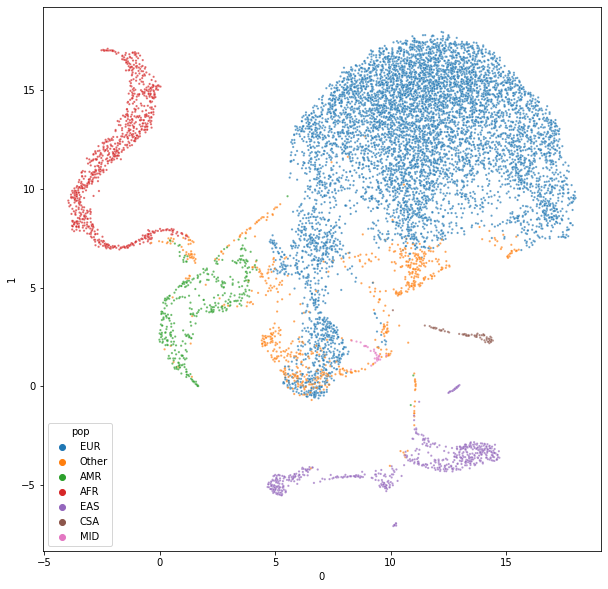

In [4]:
import umap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

ukb_predictions = hl.read_table("/mnt/grid/janowitz/rdata_norepl/tcga_germline/hail/ancestry_calls.ht")

ukb_predictions_pd = ukb_predictions.to_pandas()

data = pd.DataFrame(ukb_predictions_pd['pca_scores'].to_list())

proj_umap_pca = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.5, random_state=42).fit_transform(data)


umap = pd.DataFrame(proj_umap_pca)
umap['pop'] = ukb_predictions_pd['pop']

plt.figure(figsize=(10,10))
sns.color_palette("bright")
sns.scatterplot(data=umap, x=0, y=1, hue="pop", s=5, alpha = 0.7, marker ='o')
plt.show()

In [5]:
ukb_predictions_pd = ukb_predictions.to_pandas()

ukb_predictions_pd = ukb_predictions_pd[["s", "pop"]]
ukb_predictions_pd['pop'].value_counts()

EUR      7406
AFR       872
Other     743
EAS       618
AMR       377
CSA        67
MID        31
Name: pop, dtype: int64

#### Estimate relatedness

In [ ]:
relatedness_ht = hl.pc_relate(qc_mt.GT, 0.01, k=10, min_kinship=0.05, block_size=512)

related_samples_to_remove = hl.maximal_independent_set(relatedness_ht.i, relatedness_ht.j, False)
print(related_samples_to_remove.count())

related_samples_to_remove.write("/mnt/grid/janowitz/rdata_norepl/tcga_germline/hail/related_remove_tcga.ht",overwrite=True)

#### Visually check EUR PCA

In [10]:
import pandas as pd
from hail.plot import show
from pprint import pprint
hl.plot.output_notebook()

mt = hl.read_matrix_table('/mnt/grid/janowitz/rdata_norepl/tcga_germline/hail/qc_tcga.mt')

#Remove related samples
related_samples_to_remove = hl.read_table("/mnt/grid/janowitz/rdata_norepl/tcga_germline/hail/related_remove_tcga.ht")
mt = mt.filter_cols(~hl.is_defined(related_samples_to_remove[mt.col_key]))

#Add ancestry data
panIO_predictions = hl.read_table("/mnt/grid/janowitz/rdata_norepl/tcga_germline/hail/ancestry_calls.ht")
mt = mt.annotate_cols(pop = panIO_predictions[mt.s].pop)

mt_filter = mt.filter_cols(mt.pop=='EUR')
print(mt_filter.count(), flush=True)

eigenvalues, pcs, _ = hl.hwe_normalized_pca(mt_filter.GT, k=2)
                          
mt_filter = mt_filter.annotate_cols(scores = pcs[mt_filter.s].scores)
                          
p = hl.plot.scatter(mt_filter.scores[0],
                    mt_filter.scores[1],
                    title='PCA', xlabel='PC1', ylabel='PC2')
show(p)

Loading BokehJS ...

2021-03-24 12:17:12 Hail: INFO: Coerced sorted dataset


(126151, 7389)


2021-03-24 12:17:13 Hail: INFO: Coerced sorted dataset
2021-03-24 12:17:20 Hail: INFO: hwe_normalized_pca: running PCA using 125469 variants.
2021-03-24 12:17:20 Hail: INFO: Coerced sorted dataset
2021-03-24 12:17:27 Hail: INFO: pca: running PCA with 2 components...
2021-03-24 12:17:57 Hail: INFO: Coerced sorted dataset


#### Remove samples with call rate <99%

No samples have call rate <99%.

In [14]:
mt = hl.read_matrix_table('/mnt/grid/janowitz/rdata_norepl/tcga_germline/hail/tcga_raw_rmsexmismatch.mt')

mt = hl.sample_qc(mt, name='sample_qc')
mt = mt.filter_cols(mt.sample_qc.call_rate > 0.99, keep=False)
mt.count()

(904232, 0)

### Variant QC

Filtering by call rate, MAF and HWE in European population.

In [20]:
#Import raw data
mt = hl.read_matrix_table('/mnt/grid/janowitz/rdata_norepl/tcga_germline/hail/tcga_raw_rmsexmismatch.mt')
print(mt.count())

mt = hl.variant_qc(mt) #Default Hail variant QC pipeline
mt = mt.filter_rows(mt.variant_qc.call_rate > 0.95) #Filter by call rate > 95%
mt = mt.filter_rows(mt.variant_qc.AF[1] > 0.001) #MAF > 0.1%

#Add ancestry data
panIO_predictions = hl.read_table("/mnt/grid/janowitz/rdata_norepl/tcga_germline/hail/ancestry_calls.ht")
mt = mt.annotate_cols(pop = panIO_predictions[mt.s].pop)

#Filter to European population
mt_filter = mt.filter_cols(mt.pop=='EUR')
mt_filter = hl.variant_qc(mt_filter) #Default Hail variant QC pipeline
mt_filter = mt_filter.filter_rows(mt_filter.variant_qc.p_value_hwe > 1e-15, keep=False)

#Remove SNPs failing HW in EUR population
mt = mt.anti_join_rows(mt_filter.rows())
print(mt.count())

mt.write('/mnt/grid/janowitz/rdata_norepl/tcga_germline/hail/tcga_filtered.mt', overwrite=True)

(904232, 10114)
(869257, 10114)


2021-03-24 20:55:56 Hail: INFO: wrote matrix table with 869257 rows and 10114 columns in 17 partitions to /mnt/grid/janowitz/rdata_norepl/tcga_germline/hail/tcga_filtered.mt
    Total size: 2.52 GiB
    * Rows/entries: 2.52 GiB
    * Columns: 57.25 KiB
    * Globals: 11.00 B
    * Smallest partition: 4790 rows (2.78 MiB)
    * Largest partition:  82600 rows (246.59 MiB)


### Prepare for imputation

Extract unrelated European population for imputation. Additional excess hetero/homozygosity filtering applied, this is in additional to what was performed in the Immunity paper.

In [22]:
#Import TCGA germline data post marker QC
mt = hl.read_matrix_table('/mnt/grid/janowitz/rdata_norepl/tcga_germline/hail/tcga_filtered.mt')

#Filter to autosomal SNPs
mt = mt.filter_rows(mt.locus.in_autosome())

#Add ancestry data
panIO_predictions = hl.read_table("/mnt/grid/janowitz/rdata_norepl/tcga_germline/hail/ancestry_calls.ht")
mt = mt.annotate_cols(pop = panIO_predictions[mt.s].pop)

#Filter to European population
mt = mt.filter_cols(mt.pop=='EUR')

#Remove related samples
related_samples_to_remove = hl.read_table("/mnt/grid/janowitz/rdata_norepl/tcga_germline/hail/related_remove_tcga.ht")
mt = mt.filter_cols(~hl.is_defined(related_samples_to_remove[mt.col_key]))
print(mt.count())

#Filter excess heterozygosity in EUR subset
mt = mt.annotate_cols(IB = hl.agg.inbreeding(mt.GT, mt.variant_qc.AF[1]))
summ_stats = mt.aggregate_cols(hl.agg.stats(mt.IB.f_stat))
threshold_low = summ_stats['mean'] - (3* summ_stats['stdev'])
threshold_high = summ_stats['mean'] + (3* summ_stats['stdev'])
mt = mt.filter_cols(mt.IB.f_stat > threshold_low)
mt = mt.filter_cols(mt.IB.f_stat < threshold_high)
print(mt.count())

hl.export_vcf(mt, '/mnt/grid/janowitz/rdata_norepl/tcga_germline/hail/tcga_forimputation.vcf')

2021-03-24 21:04:30 Hail: INFO: Coerced sorted dataset


(862153, 7389)


2021-03-24 21:04:31 Hail: INFO: Coerced sorted dataset
2021-03-24 21:05:09 Hail: INFO: Coerced sorted dataset
2021-03-24 21:05:10 Hail: INFO: Coerced sorted dataset
2021-03-24 21:05:49 Hail: INFO: Coerced sorted dataset


(862153, 7260)


2021-03-24 21:05:50 Hail: WARN: export_vcf: ignored the following fields:
    'pop' (column)
    'IB' (column)
    'variant_qc' (row)
2021-03-24 21:05:50 Hail: INFO: Coerced sorted dataset
2021-03-24 21:06:33 Hail: INFO: Coerced sorted dataset
2021-03-24 21:07:55 Hail: INFO: merging 17 files totalling 23.4G...
2021-03-24 21:08:30 Hail: INFO: while writing:
    /mnt/grid/janowitz/rdata_norepl/tcga_germline/hail/tcga_forimputation.vcf
  merge time: 35.029s


### Filter imputed data

TOPMED outputs as GRCh38, filter to RSQ > 0.6.

In [ ]:
mt = hl.import_vcf('/mnt/grid/janowitz/rdata_norepl/tcga_germline/imputed/chr*.dose.vcf.gz', force_bgz=True)
mt = mt.filter_rows(mt.info.R2 >= 0.6)

mt.write('/mnt/grid/janowitz/rdata_norepl/tcga_germline/hail/tcga_imputed_info0.6.mt', overwrite=True)

### Generate cleaned dataset

#### GRCh37

In [ ]:
#Import TCGA germline data post marker QC
mt = hl.read_matrix_table('/mnt/grid/janowitz/rdata_norepl/tcga_germline/hail/tcga_imputed_info0.6.mt')
mt_filter = hl.read_matrix_table('/mnt/grid/janowitz/rdata_norepl/tcga_germline/hail/qc_tcga.mt')

#Filter to autosomal SNPs with MAF >0.1%
mt = mt.filter_rows(mt.locus.in_autosome())
mt = hl.variant_qc(mt) #Default Hail variant QC pipeline
mt = mt.filter_rows(mt.variant_qc.AF[1] > 0.001) #MAF > 0.1%

#Add ancestry data
panIO_predictions = hl.read_table("/mnt/grid/janowitz/rdata_norepl/tcga_germline/hail/ancestry_calls.ht")
mt = mt.annotate_cols(pop = panIO_predictions[mt.s].pop)
mt_filter = mt_filter.annotate_cols(pop = panIO_predictions[mt_filter.s].pop)

#Filter to European population
mt = mt.filter_cols(mt.pop=='EUR')
mt_filter = mt_filter.filter_cols(mt_filter.pop=='EUR')

#Remove related samples
related_samples_to_remove = hl.read_table("/mnt/grid/janowitz/rdata_norepl/tcga_germline/hail/related_remove_tcga.ht")
mt = mt.filter_cols(~hl.is_defined(related_samples_to_remove[mt.col_key]))
mt_filter = mt_filter.filter_cols(~hl.is_defined(related_samples_to_remove[mt_filter.col_key]))

print(mt.count())
print(mt_filter.count())

#Liftover to GRCh37
mt = default_lift_data(mt)

#Generate principal components from high-quality SNPs with MAF >1% (selected above)
#_, scores_pca_ref, _ = hl.hwe_normalized_pca(mt_filter.GT, k=4)

#p = hl.plot.scatter(scores_pca_ref.scores[0],
#                    scores_pca_ref.scores[1],
#                    title='PCA', xlabel='PC1', ylabel='PC2')
#show(p)

#scores_pca_ref = scores_pca_ref.transmute(**{f'PC{i}': scores_pca_ref.scores[i - 1] for i in range(1, 5)})
#scores_pd = scores_pca_ref.to_pandas()
#scores_pd = scores_pd.rename(columns={'s': 'IID'})

#scores_pd.to_csv('/mnt/grid/janowitz/rdata_norepl/tcga_germline/plink/tcga_eur_pcs.tsv', sep="\t", index=False)

#Filter to PGS SNPs, annotate with dbSNP ID
snplist = hl.read_table('/mnt/grid/ukbiobank/data/Application58510/skleeman/gwas_cystatinc/PRS/snplist/innersnps.ht')
mt = mt.semi_join_rows(snplist)
mt = mt.annotate_rows(rsid = snplist[mt.locus, mt.alleles].rsid)

#Save as PLINK file
hl.export_plink(mt, '/mnt/grid/janowitz/rdata_norepl/tcga_germline/plink/tcga_grch37_maf0.001_inner',
                ind_id = mt.s, varid = mt.rsid)

2021-03-27 21:45:31 Hail: WARN: cols(): Resulting column table is sorted by 'col_key'.
    To preserve matrix table column order, first unkey columns with 'key_cols_by()'
2021-03-27 21:45:35 Hail: INFO: Coerced sorted dataset


#### GRCh38

In [2]:
#Import TCGA germline data post marker QC
mt = hl.read_matrix_table('/mnt/grid/janowitz/rdata_norepl/tcga_germline/hail/tcga_imputed_info0.6.mt')
mt_filter = hl.read_matrix_table('/mnt/grid/janowitz/rdata_norepl/tcga_germline/hail/qc_tcga.mt')

#Filter to autosomal SNPs with MAF >0.1%
mt = mt.filter_rows(mt.locus.in_autosome())
mt = hl.variant_qc(mt) #Default Hail variant QC pipeline
mt = mt.filter_rows(mt.variant_qc.AF[1] > 0.001) #MAF > 0.1%

#Add ancestry data
panIO_predictions = hl.read_table("/mnt/grid/janowitz/rdata_norepl/tcga_germline/hail/ancestry_calls.ht")
mt = mt.annotate_cols(pop = panIO_predictions[mt.s].pop)
mt_filter = mt_filter.annotate_cols(pop = panIO_predictions[mt_filter.s].pop)

#Filter to European population
mt = mt.filter_cols(mt.pop=='EUR')
mt_filter = mt_filter.filter_cols(mt_filter.pop=='EUR')

#Remove related samples
related_samples_to_remove = hl.read_table("/mnt/grid/janowitz/rdata_norepl/tcga_germline/hail/related_remove_tcga.ht")
mt = mt.filter_cols(~hl.is_defined(related_samples_to_remove[mt.col_key]))
mt_filter = mt_filter.filter_cols(~hl.is_defined(related_samples_to_remove[mt_filter.col_key]))

print(mt.count())
print(mt_filter.count())
mt_filter.write('/mnt/grid/janowitz/rdata_norepl/tcga_germline/hail/tcga_imputed_info0.6_European.mt', overwrite=True)

2022-04-20 15:20:25 Hail: WARN: cols(): Resulting column table is sorted by 'col_key'.
    To preserve matrix table column order, first unkey columns with 'key_cols_by()'
2022-04-20 15:20:29 Hail: INFO: Coerced sorted dataset


(13960515, 7260)


2022-04-20 15:40:50 Hail: INFO: Coerced sorted dataset


(126151, 7389)


2022-04-20 15:40:51 Hail: INFO: Coerced sorted dataset
2022-04-20 15:41:26 Hail: INFO: wrote matrix table with 126151 rows and 7389 columns in 17 partitions to /mnt/grid/janowitz/rdata_norepl/tcga_germline/hail/tcga_imputed_info0.6_European.mt
    Total size: 215.06 MiB
    * Rows/entries: 215.02 MiB
    * Columns: 39.98 KiB
    * Globals: 11.00 B
    * Smallest partition: 2885 rows (3.93 MiB)
    * Largest partition:  13687 rows (24.22 MiB)


## GTEX QC

Import GTEX data downloaded from dbGap. They provide data following extensive QC and no additional steps are required from our perspective, apart from ancestry calling and double-checking no-one is >=3rd degree related. Data is GRCh38.

In [ ]:
mt = hl.import_vcf('/mnt/grid/janowitz/rdata_norepl/gtex/phg001219.v1.GTEx_v8_WGS.genotype-calls-vcf.c1/GTEx_Analysis_2017-06-05_v8_WholeGenomeSeq_838Indiv_Analysis_Freeze.vcf.gz', force_bgz=True,
                   reference_genome='GRCh38')

mt = mt.checkpoint('/mnt/grid/janowitz/rdata_norepl/gtex/hail/gtex_raw.mt', overwrite=True)

### Sample QC

#### Ancestry calling

Perform ancestry calling with MAF >1% as otherwise we are including >1 million variants in the PCA.

In [ ]:
from gnomad.utils.liftover import *
from gnomad.utils.annotations import *
from gnomad.sample_qc.pipeline import *
from gnomad.sample_qc.ancestry import *

mt = hl.read_matrix_table('/mnt/grid/janowitz/rdata_norepl/gtex/hail/gtex_raw.mt')

#Exclude LD intervals from plinkQC package, LD pruning in PLINK (not working in Hail due to bug)
intervals = hl.import_bed('/mnt/grid/janowitz/home/skleeman/ukbiobank/cancergwas/remove_ld_grch38.bed',
                         reference_genome='GRCh38')
mt = mt.filter_rows(hl.is_defined(intervals[mt.locus]),keep=False)

qc_mt = get_qc_mt(
    mt,
    min_af=0.01,
    min_inbreeding_coeff_threshold=-0.025,
    ld_r2=0.1,
    apply_hard_filters = True,
    min_callrate=0.99,
    filter_lcr=False,
    filter_decoy=False,
    filter_segdup=False
)

qc_mt = qc_mt.checkpoint('/mnt/grid/janowitz/rdata_norepl/gtex/hail/gtex_qc.mt', overwrite=True)

#Import 1000G/HGDP reference
this_ref = hl.read_matrix_table('/mnt/grid/janowitz/home/references/1k_hgdp/ref_gnomadfilters.mt')
related_samples_to_remove_ref = hl.read_table("/mnt/grid/janowitz/home/references/1k_hgdp/related_remove_ref.ht")

#Merge cohorts
tcga_in_ref = qc_mt.filter_rows(hl.is_defined(this_ref.rows()[qc_mt.row_key]))
print('sites in ref and TCGA data, inds in TCGA: ' + str(tcga_in_ref.count()))

ref_in_tcga= this_ref.filter_rows(hl.is_defined(qc_mt.rows()[this_ref.row_key]))
print('sites in ref and TCGA data, inds in ref: ' + str(ref_in_tcga.count()))

tcga_in_ref = tcga_in_ref.checkpoint('/mnt/grid/janowitz/rdata_norepl/gtex/hail/GTEX_in_ref.mt', overwrite=True)
ref_in_tcga = ref_in_tcga.checkpoint('/mnt/grid/janowitz/rdata_norepl/gtex/hail/ref_in_GTEX.mt', overwrite=True)

#Ancestry PCA
#--> Reference, label with inferred populations, exclude relateds
_, scores_pca_ref, loadings_pca_ref = run_pca_with_relateds(ref_in_tcga, related_samples_to_remove_ref, 
                                                               n_pcs=10, autosomes_only=True)

#--> Project to PanIO

scores_pca_tcga = pc_project(mt = tcga_in_ref, loadings_ht = loadings_pca_ref)

#Train RF classifier
merge = scores_pca_ref.union(scores_pca_tcga)

merge = merge.annotate(
    training_pop=this_ref.cols()[merge.key].labeled_subpop)

recode = pd.read_excel('/mnt/grid/janowitz/home/references/1k_hgdp/recode.xlsx')
recode_ht = hl.Table.from_pandas(recode, key='labeled_subpop')

merge = merge.annotate(
    training_pop=recode_ht[merge.training_pop].superpop)

predictions_ref, classifer_rf_ref = assign_population_pcs(merge, pc_cols = merge.scores, known_col = 'training_pop', seed=501, min_prob = 0.70, missing_label='Other')

tcga_predictions = predictions_ref.semi_join(scores_pca_tcga) #Subset PanIO samples

tcga_predictions.write("/mnt/grid/janowitz/rdata_norepl/gtex/hail/ancestry_calls.ht", overwrite=True)

#### Estimate relatedness

9 samples have >=3rd degree relatedness and so should be removed.

In [ ]:
relatedness_ht = hl.pc_relate(qc_mt.GT, 0.01, k=10, min_kinship=0.05, block_size=512)

related_samples_to_remove = hl.maximal_independent_set(relatedness_ht.i, relatedness_ht.j, False)
print(related_samples_to_remove.count())

related_samples_to_remove.write("/mnt/grid/janowitz/rdata_norepl/gtex/hail/related_remove_GTEX.ht",overwrite=True)

#### Visualize ancestry

/grid/wsbs/home_norepl/skleeman/.local/lib/python3.7/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


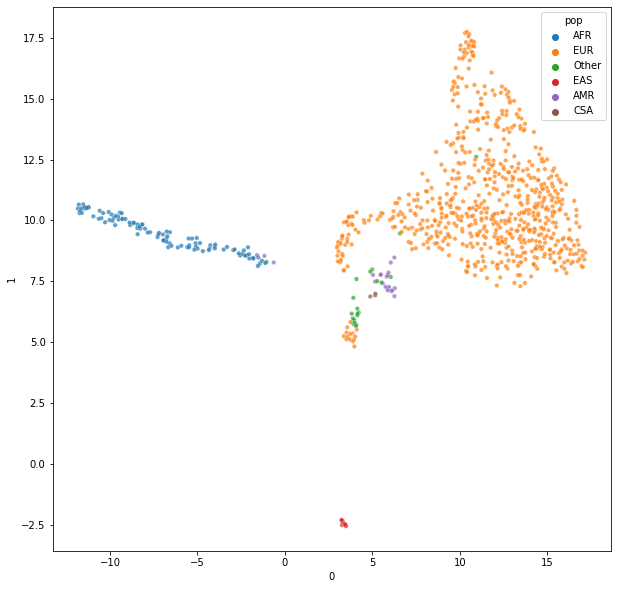

In [30]:
import umap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

ukb_predictions = hl.read_table("/mnt/grid/janowitz/rdata_norepl/gtex/hail/ancestry_calls.ht")

ukb_predictions_pd = ukb_predictions.to_pandas()

data = pd.DataFrame(ukb_predictions_pd['pca_scores'].to_list())

proj_umap_pca = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.5, random_state=42).fit_transform(data)


umap = pd.DataFrame(proj_umap_pca)
umap['pop'] = ukb_predictions_pd['pop']

plt.figure(figsize=(10,10))
sns.color_palette("bright")
sns.scatterplot(data=umap, x=0, y=1, hue="pop", s=20, alpha = 0.7, marker ='o')
plt.show()

In [8]:
ukb_predictions_pd = ukb_predictions.to_pandas()

ukb_predictions_pd = ukb_predictions_pd[["s", "pop"]]
ukb_predictions_pd['pop'].value_counts()

EUR      668
AFR      100
Other     35
AMR       22
EAS       10
CSA        3
Name: pop, dtype: int64

#### Refine EUR ancestry

Iterateively remove subjects with PCA Z-score > 5, completed 3 cycles of this pruning process in order to get a homogenous appearing PCA.

In [ ]:
import pandas as pd
from gnomad.sample_qc.pipeline import *
from gnomad.sample_qc.ancestry import *
from hail.plot import show
from pprint import pprint
hl.plot.output_notebook()

mt = hl.read_matrix_table('/mnt/grid/janowitz/rdata_norepl/gtex/hail/gtex_qc.mt')

#Load related samples
related_samples_to_remove = hl.read_table("/mnt/grid/janowitz/rdata_norepl/gtex/hail/related_remove_GTEX.ht")
mt = mt.filter_cols(~hl.is_defined(related_samples_to_remove[mt.col_key]))

#Add ancestry data
panIO_predictions = hl.read_table("/mnt/grid/janowitz/rdata_norepl/gtex/hail/ancestry_calls_update2.ht")
mt = mt.annotate_cols(pop = panIO_predictions[mt.s].pop)

mt_filter = mt.filter_cols(mt.pop=='EUR')
mt_filter = hl.variant_qc(mt_filter) 
mt_filter = mt_filter.filter_rows(mt_filter.variant_qc.AF[1] > 0.01) #MAF > 1% to speed up PCA

print(mt_filter.count(), flush=True)


#Run PCA excluding relateds then project onto everyone
_, pcs, _ = hl.hwe_normalized_pca(mt_filter.GT, k=2)

    
scores_pca_ref = pcs
scores_pca_ref = scores_pca_ref.transmute(**{f'PC{i}': scores_pca_ref.scores[i - 1] for i in range(1, 3)})


scores_pca_ref = scores_pca_ref.annotate(PC1_Z = ((scores_pca_ref.PC1 - scores_pca_ref.aggregate(hl.agg.mean(scores_pca_ref.PC1))) / (scores_pca_ref.aggregate(hl.agg.stats(scores_pca_ref.PC1).stdev))),
                        PC2_Z = ((scores_pca_ref.PC2 - scores_pca_ref.aggregate(hl.agg.mean(scores_pca_ref.PC2))) / (scores_pca_ref.aggregate(hl.agg.stats(scores_pca_ref.PC2).stdev))))

p = hl.plot.scatter(scores_pca_ref.PC1_Z,
                    scores_pca_ref.PC2_Z,
                    title='PCA', xlabel='PC1', ylabel='PC2')
show(p)

scores_pca_ref = scores_pca_ref.filter((hl.abs(scores_pca_ref.PC1_Z) <5) & (hl.abs(scores_pca_ref.PC2_Z) <5), keep=False)
print(scores_pca_ref.count())

panIO_predictions = panIO_predictions.annotate(pop = hl.case()
                                              .when(hl.is_defined(scores_pca_ref[panIO_predictions.s]), "Other")
                                              .default(panIO_predictions.pop))

panIO_predictions_pd = panIO_predictions.to_pandas()
panIO_predictions_pd = panIO_predictions_pd[["s", "pop"]]
panIO_predictions_pd['pop'].value_counts()


panIO_predictions.write("/mnt/grid/janowitz/rdata_norepl/gtex/hail/ancestry_calls_update3.ht", overwrite=True)


Check results, looking for homogenous-appearing PCA.

In [13]:
import pandas as pd
from hail.plot import show
from pprint import pprint
hl.plot.output_notebook()

mt = hl.read_matrix_table('/mnt/grid/janowitz/rdata_norepl/gtex/hail/gtex_qc.mt')

#Remove related samples
related_samples_to_remove = hl.read_table("/mnt/grid/janowitz/rdata_norepl/gtex/hail/related_remove_GTEX.ht")
mt = mt.filter_cols(~hl.is_defined(related_samples_to_remove[mt.col_key]))

#Add ancestry data
panIO_predictions = hl.read_table("/mnt/grid/janowitz/rdata_norepl/gtex/hail/ancestry_calls_update3.ht")
mt = mt.annotate_cols(pop = panIO_predictions[mt.s].pop)

mt_filter = mt.filter_cols(mt.pop=='EUR')
mt_filter = hl.variant_qc(mt_filter) 
mt_filter = mt_filter.filter_rows(mt_filter.variant_qc.AF[1] > 0.01) #MAF > 1% to speed up PCA

print(mt_filter.count(), flush=True)

#Run PCA
_, pcs, _ = hl.hwe_normalized_pca(mt_filter.GT, k=2)

#Plot PCA
mt_filter = mt_filter.annotate_cols(scores = pcs[mt_filter.s].scores)
                          
p = hl.plot.scatter(mt_filter.scores[0],
                    mt_filter.scores[1],
                    title='PCA', xlabel='PC1', ylabel='PC2')
show(p)

Loading BokehJS ...

2021-03-26 15:41:36 Hail: INFO: Coerced sorted dataset


(406162, 678)


2021-03-26 15:41:46 Hail: INFO: Coerced sorted dataset
2021-03-26 15:41:55 Hail: INFO: hwe_normalized_pca: running PCA using 399825 variants.
2021-03-26 15:41:56 Hail: INFO: Coerced sorted dataset
2021-03-26 15:42:05 Hail: INFO: pca: running PCA with 2 components...
2021-03-26 15:44:11 Hail: INFO: Coerced sorted dataset


### Generate cleaned dataset

#### GRCh38

In [ ]:
#Import TCGA germline data post marker QC
mt = hl.read_matrix_table('/mnt/grid/janowitz/rdata_norepl/gtex/hail/gtex_raw.mt')
mt_filter = hl.read_matrix_table('/mnt/grid/janowitz/rdata_norepl/gtex/hail/gtex_qc.mt')

#Filter to autosomal SNPs with MAF >0.1%
mt = mt.filter_rows(mt.locus.in_autosome())
mt = hl.variant_qc(mt) #Default Hail variant QC pipeline
mt = mt.filter_rows(mt.variant_qc.AF[1] > 0.001) #MAF > 0.1%

#Add ancestry data
panIO_predictions = hl.read_table("/mnt/grid/janowitz/rdata_norepl/gtex/hail/ancestry_calls_update3.ht")
mt = mt.annotate_cols(pop = panIO_predictions[mt.s].pop)
mt_filter = mt_filter.annotate_cols(pop = panIO_predictions[mt_filter.s].pop)

#Filter to European population
mt = mt.filter_cols(mt.pop=='EUR')
mt_filter = mt_filter.filter_cols(mt_filter.pop=='EUR')

#Remove related samples
related_samples_to_remove = hl.read_table("/mnt/grid/janowitz/rdata_norepl/gtex/hail/related_remove_GTEX.ht")
mt = mt.filter_cols(~hl.is_defined(related_samples_to_remove[mt.col_key]))
mt_filter = mt_filter.filter_cols(~hl.is_defined(related_samples_to_remove[mt_filter.col_key]))

print(mt.count())
print(mt_filter.count())

#Liftover to GRCh37
mt = default_lift_data(mt)

#Generate principal components from high-quality SNPs with MAF >1% (selected above)
mt_filter = hl.variant_qc(mt_filter) 
mt_filter = mt_filter.filter_rows(mt_filter.variant_qc.AF[1] > 0.01) #MAF > 1% to speed up PCA
#_, scores_pca_ref, _ = hl.hwe_normalized_pca(mt_filter.GT, k=4)

#p = hl.plot.scatter(scores_pca_ref.scores[0],
#                    scores_pca_ref.scores[1],
#                    title='PCA', xlabel='PC1', ylabel='PC2')
#show(p)

#scores_pca_ref = scores_pca_ref.transmute(**{f'PC{i}': scores_pca_ref.scores[i - 1] for i in range(1, 5)})
#scores_pd = scores_pca_ref.to_pandas()
#scores_pd = scores_pd.rename(columns={'s': 'IID'})

#scores_pd.to_csv('/mnt/grid/janowitz/rdata_norepl/gtex/plink/gtex_eur_pcs.tsv', sep="\t", index=False)

#Filter to PGS SNPs, annotate with dbSNP ID
snplist = hl.read_table('/mnt/grid/ukbiobank/data/Application58510/skleeman/gwas_cystatinc/PRS/snplist/innersnps.ht')
mt = mt.semi_join_rows(snplist)
mt = mt.annotate_rows(rsid = snplist[mt.locus, mt.alleles].rsid)

#Save as PLINK file
hl.export_plink(mt, '/mnt/grid/janowitz/rdata_norepl/gtex/plink/gtex_grch37_maf0.001_inner',
                ind_id = mt.s, varid = mt.rsid)